# Project Machine Learning for cybersecurity : Anti Malware System - A Deep Learning Approach using Support Vector Machine (SVM) for Malware Classification


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Charger le fichier NPZ
data = np.load('images_malware.npz', allow_pickle=True)

# Afficher les clés disponibles dans le fichier NPZ
print("Clés disponibles dans le fichier NPZ :", list(data.keys()))

# Afficher les valeurs associées à chaque clé
for key in data.keys():
    print(f"Clé : {key}")
    print(data[key])  # Afficher la valeur associée à la clé

Clés disponibles dans le fichier NPZ : ['arr']
Clé : arr
[[array([[  0,   0,   0, ...,   0,   0,   0],
         [ 24,   0,  69, ...,   0, 144, 255],
         [232, 242, 251, ..., 235, 139,   0],
         ...,
         [ 88, 124, 124, ...,  95,  92,  56],
         [ 27, 243, 250, ..., 250, 243, 243],
         [115,  48, 129, ..., 199,  23, 252]], dtype=uint8) 0]
 [array([[  0,   0,   0, ...,   0,   0,   0],
         [ 24,   0,  69, ...,   0, 144, 255],
         [139, 139, 209, ..., 139,   2, 196],
         ...,
         [ 35,  44,  40, ...,  88, 124,  37],
         [233, 248, 134, ...,  27,  32, 247],
         [134,  19, 252, ..., 137, 176,  43]], dtype=uint8) 0]
 [array([[  0,   0,   0, ...,   0,   0,   0],
         [ 24,   0,  69, ...,   0, 144, 255],
         [232, 242, 251, ..., 235, 139,   0],
         ...,
         [ 88, 124, 124, ...,  95,  92,  56],
         [ 27, 243, 250, ..., 250, 243, 243],
         [115,  48, 129, ..., 199,  23, 252]], dtype=uint8) 0]
 ...
 [array([[  0,  8

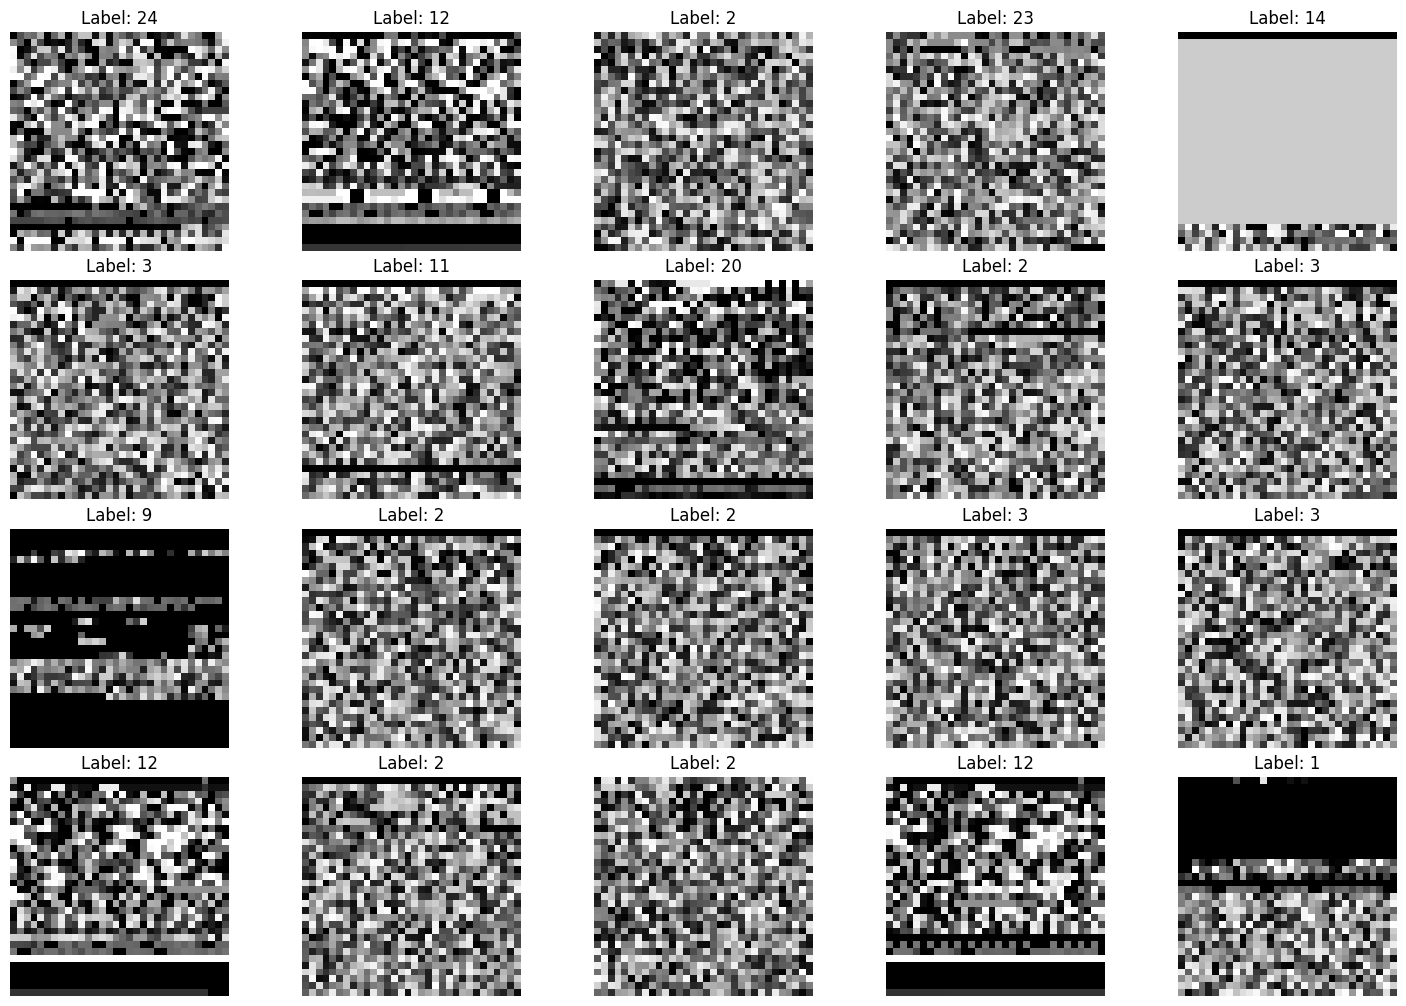

In [4]:
# Récupérer les données
images = data['arr'][:, 0]  # Supposons que les images sont dans la première colonne
labels = data['arr'][:, 1]  # Supposons que les étiquettes sont dans la deuxième colonne

# Nombre total d'images dans le dataset
total_images = len(images)

# Sélectionner 20 indices au hasard
random_indices = np.random.choice(total_images, size=20, replace=False)

# Afficher les images sélectionnées aléatoirement avec leurs étiquettes
num_images_per_row = 5
num_rows = (len(random_indices) - 1) // num_images_per_row + 1

plt.figure(figsize=(15, 10))  # Taille de la figure

for i, idx in enumerate(random_indices):
    plt.subplot(num_rows, num_images_per_row, i + 1)
    plt.imshow(images[idx], cmap='gray')  # Affichage en nuances de gris
    plt.title(f'Label: {labels[idx]}')
    plt.axis('off')  # Désactiver les axes

plt.tight_layout(pad=0.5)  # Ajuster la disposition pour un espacement optimal
plt.show()

In [5]:
# Charger les données
data = np.load('images_malware.npz', allow_pickle=True)
images_labels = data['arr']

# Séparer les images et les étiquettes
images = []
labels = []
for img, label in images_labels:
    images.append(img)
    labels.append(label)

# Convertir en tableaux NumPy
images = np.array(images)
labels = np.array(labels)

# Conversion des images en tenseurs PyTorch
images_tensor = torch.from_numpy(images).float()
labels_tensor = torch.from_numpy(labels).long()

print("Data Type Image Tensor :", images_tensor.dtype)
print("Data Type Label Tensor :", labels_tensor.dtype)
print("Data Shape Image Tensor :", images_tensor.shape)
print("Data Shape Label Tensor :", labels_tensor.shape)


Data Type Image Tensor : torch.float32
Data Type Label Tensor : torch.int64
Data Shape Image Tensor : torch.Size([9339, 32, 32])
Data Shape Label Tensor : torch.Size([9339])


In [6]:
# Définir le modèle CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 36, kernel_size=5, stride=1, padding=2)
        self.leaky_relu1 = nn.LeakyReLU(0.01)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(36, 72, kernel_size=5, stride=1, padding=2)
        self.leaky_relu2 = nn.LeakyReLU(0.01)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(72 * 8 * 8, 1024)
        self.leaky_relu3 = nn.LeakyReLU(0.01)
        self.dropout = nn.Dropout(p=0.85)
        self.fc2 = nn.Linear(1024, 25)

    def forward(self, x):
        x = self.pool1(self.leaky_relu1(self.conv1(x)))
        x = self.pool2(self.leaky_relu2(self.conv2(x)))
        x = x.view(-1, 72 * 8 * 8)  # Ajustement de la taille avant la couche FC
        x = self.dropout(self.leaky_relu3(self.fc1(x)))
        x = self.fc2(x)
        return x


# Créer un TensorDataset
dataset = TensorDataset(images_tensor, labels_tensor)

# DataLoader
batch_size = 256
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = CNN()

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)


In [7]:
# Entraîner le modèle
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))  # Ajouter la dimension du canal
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(data_loader)}')

Epoch [1/5], Loss: 4.639302389041798
Epoch [2/5], Loss: 2.131588423574293
Epoch [3/5], Loss: 1.8738582424215369
Epoch [4/5], Loss: 1.6742566082928632
Epoch [5/5], Loss: 1.5032138534494348


In [9]:
from sklearn.svm import SVC

# Récupérer les embeddings des images après la première couche FC
def get_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    targets = []
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data
            outputs = model(inputs.unsqueeze(1))
            # Aplatir les embeddings pour les rendre compatibles avec le SVM
            embeddings.extend(outputs.view(outputs.size(0), -1).detach().numpy())
            targets.extend(labels.detach().numpy())
    return embeddings, targets

# Obtenir les embeddings
embeddings, targets = get_embeddings(model, data_loader)

# Entraîner le SVM
svm = SVC(C=10, kernel='linear')
svm.fit(embeddings, targets)

SVC(C=10, kernel='linear')